In [ ]:
import numpy as np
import cv2
import os
import pickle
import glob
from sklearn.utils import shuffle 
from sklearn import svm,metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/alessiocorrado99/animals10")

Skipping, found downloaded files in "./animals10" (use force=True to force download)


In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.preprocessing import image
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model
import numpy as np

In [ ]:
from pathlib import Path
ds_path = Path('/content/animals10/raw-img')

In [ ]:
dsize = (224,224)

In [ ]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = gen.flow_from_directory("/content/animals10/raw-img/",  
                                                target_size=(256,256), 
                                                batch_size=32,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')  

val_generator = gen.flow_from_directory("/content/animals10/raw-img/",
                                                    target_size=(256,256),
                                                    batch_size=32,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
base_convnet = VGG16(include_top=False, input_shape=input_shape,
                     weights='imagenet')


#Freeze base convolutional layers
base_convnet.trainable = False
base_convnet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(base_convnet)
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(3, activation='softmax'))

model.build(input_shape=(None,224,224,3))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

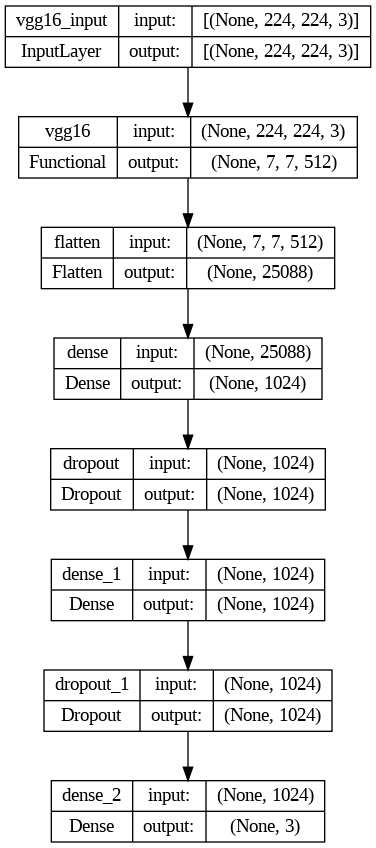

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
opt_rms = keras.optimizers.legacy.RMSprop(learning_rate=0.001,decay=1e-6)

with tf.device('/device:GPU:0'):

  cbs = [EarlyStopping(patience=3, restore_best_weights=True),
         ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2)]

  # model.compile(loss = "categorical_crossentropy", optimizer = "adam",
  #               metrics = "accuracy")
  
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [ ]:
# # create model with different layers
# model = tf.keras.Sequential()

# model.add(tf.keras.layers.InputLayer(input_shape=(128,3)))

# model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=10))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(tf.keras.layers.ReLU())
# model.add(tf.keras.layers.GlobalAveragePooling1D())
# model.add(tf.keras.layers.Dense(units=6, activation=tf.nn.softmax))


# # compile model and prepare tensorBoard
# model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# track training in TensorBoard
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir)]

# run the model
model.fit(train_generator, epochs=100, batch_size=32, callbacks=callbacks, validation_data=val_generator)

# model.fit(train_generator,steps_per_epoch =10,validation_data=val_generator,validation_steps=10,epochs=10,verbose=2)


Epoch 1/100


InvalidArgumentError: ignored

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_name = "model.h5"
Checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only = True, verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, restore_best_weights=True)

In [ ]:
model.fit(
    train_generator, 
    validation_data=val_generator,
    epochs = 2)

Epoch 1/2


InvalidArgumentError: ignored

In [ ]:
history = model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[Checkpoint,es])

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
# train_x = np.asarray(train_x)
train_y = np.asarray(train_generator)
# validation_x = np.asarray(validation_x)
# validation_y = np.asarray(validation_y)

In [ ]:
model.fit(train_generator, epochs=2, steps_per_epoch=10)
print('My custom loss: ', model.loss_tracker.result().numpy())

Epoch 1/2


InvalidArgumentError: ignored

In [ ]:
model.fit(
    train_generator,
    batch_size=32,
    epochs=10,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=val_generator,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=10,
    validation_steps=10,
    validation_batch_size=32,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
model.fit(train_generator,steps_per_epoch =10,validation_data=val_generator,validation_steps=10,epochs=10,verbose=2)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
model.fit(train_generator,steps_per_epoch =5,epochs=23,validation_data=val_generator,validation_steps=5)


Epoch 1/23


InvalidArgumentError: ignored